Iota Calculation and Fourier Surface Extraction (Wendelstein 7-X)
=================================================================

This example shows how to calculate the rotational transform for Wendelstein 7-X. 

In [1]:
import fusionsc as fsc
from fusionsc.devices import w7x
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import importlib
importlib.reload(fsc.magnetics)
importlib.reload(fsc.flt)

<module 'fusionsc.flt' from 'C:\\Users\\Knieps\\Documents\\repos\\fsc\\src\\python\\fusionsc\\flt.py'>

First, we need to perform some setup to make sure W7-X data are available.

Note: The W7-X geometry is currently protected by the W7-X data access agreement. Therefore, the file referenced below is available to W7-X team members (including external collaborators who signed this agreement) upon request.

In [3]:
fsc.resolve.importOfflineData('../../w7x-op21.fsc')

Now we need to setup the geometry and magnetic field configuration. To speed up the magnetic field calculation, we use a slightly coarser grid.

In [4]:
field = w7x.standard()

grid = w7x.defaultGrid()
grid.nR = 32
grid.nZ = 32
grid.nPhi = 32

field = field.compute(grid)
await field

Finally, we need to decide in which phi planes we want to evaluate our iota and start our surfaces from.

In [44]:
xStart = np.linspace(5.65, 6.3, 30)
yStart = 0 * xStart
zStart = 0 * xStart

Now it's time to run our calculation.

In [5]:
iotas = fsc.flt.calculateIota(
    field, [xStart, yStart, zStart],
    200, # Turn count
    unwrapEvery = 10, distanceLimit = 1e4, 
    targetError = 1e-3, minStepSize = 1e-3
)

The iota profile is returned in a shape matching the start point shape, and can be easily plotted.

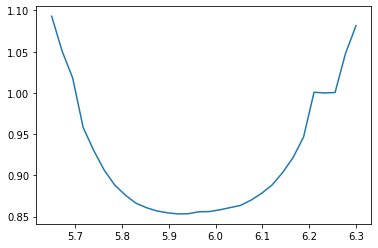

In [6]:
plt.plot(xStart, iotas)

Additionally, the field line tracer can also extract the Fourier decomposition of the magnetic surfaces from the field line. 

In [45]:
modes = fsc.flt.calculateFourierModes(
    field, [xStart, yStart, zStart],
    200, # Turn count
    nMax = 5, mMax = 5, toroidalSymmetry = 5,
    unwrapEvery = 10, recordEvery = 10,
    targetError = 1e-3, distanceLimit = 1e5,
    stellaratorSymmetric = True
)

The modes are returned with a dict containing rotational transform and the Fourier expansion of the modes, as well as an encoding of the result as a FourierSurfaces object that can also be used in VMEC inputs.

In [46]:
modes.keys()

dict_keys(['surfaces', 'iota', 'theta', 'rCos', 'zSin', 'mPol', 'nTor'])

Of particular interest are two components: The first one is the 'iota' array, which returns the rotational transforms.

In [47]:
modes["iota"]

array([1.09447588, 1.05247213, 1.01666022, 0.9602022 , 0.93233484,
       0.90942027, 0.8912811 , 0.87845593, 0.86940964, 0.86348805,
       0.85972598, 0.85709404, 0.85602258, 0.85346657, 0.85460789,
       0.85649626, 0.85789374, 0.8605038 , 0.86435725, 0.87004013,
       0.87795422, 0.88875366, 0.90336695, 0.92213986, 0.94644839,
       1.00000732, 0.9999624 , 0.9999996 , 1.0477615 , 1.08245534])

Secondarily relevant is the 'surfaces' element, which contains the magnetic surfaces. This is an instance of the class fusionsc.magnetics.SurfaceArray, which can be sliced, added, and multiplied similar to a regular NumPy array.

In [49]:
surfaces = modes["surfaces"]

print(type(surfaces))
print("First:\n", surfaces[0])
print("Last:\n", surfaces[-1])
print("Average:\n", (surfaces[0] + surfaces[-1]) / 2)

<class 'fusionsc.magnetics.SurfaceArray'>
First:
 rCos:
  shape: [11, 6]
  data: [5.433495606933926, 0.62934012052192578, 0.10906450150603952, 0.01023771217444845, 0.0057261060936157418, 0.0020260640936491992, 0.17186549616022354, 0.011487550632467491, 0.018125605467325532, 0.0073610057182727923, 9.9483294447493334e-06, -0.0013958421009093733, -0.0058316631723701728, -0.0037576772329934549, 0.00060531616808853924, -0.00072996428893735402, 0.00073796028283864635, 0.0010258082770290208, 0.00030666678122216783, -0.0032796385333975029, 0.00073017465446798858, -0.00028204930781126035, 0.00039809106063257589, -5.2255900443303403e-05, -0.00072191292822870235, -0.0012736713943955183, -6.0733946840708258e-05, -0.0014625130563672617, 0.00057291780486543585, 0.0011787244797056701, 0.00064857861481159597, -0.0005706883342531168, -0.00012046447417305811, 0.0027348598114072535, -0.0027737003574694243, -0.00038106829329795974, 0, 0.001697008509408865, -0.00058966092860279599, -0.00084225501363475346,

In [50]:
modes["theta"]

array([ 2.72059731e+00,  3.03995217e+00,  2.05986030e+00,  3.00755935e+00,
        2.99723189e+00,  3.03481665e+00,  3.01374355e+00,  3.00912547e+00,
        3.04094965e+00,  3.04569230e+00,  3.04157960e+00,  3.02792888e+00,
        3.04225458e+00,  3.01909746e+00, -8.90831502e-03,  5.91743289e-03,
       -2.00336966e-02, -2.62247837e-02, -2.47317720e-03,  1.54213401e-02,
       -1.05742398e-02, -2.00807365e-02,  1.13339854e-02,  4.66026507e-03,
       -2.51622200e-02,  8.51731232e-02, -1.80002647e-02,  3.10644120e-01,
       -9.47747656e-02, -4.18862949e-03])

To plot the modes, we need to multiply the Fourier coefficients with the appropriate angles.

(3, 6, 3, 100)


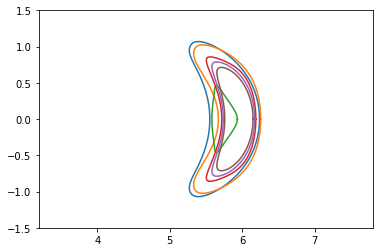

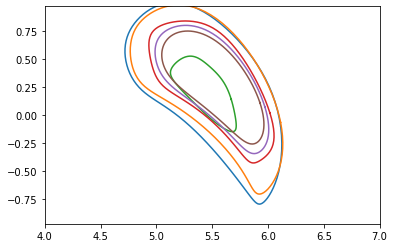

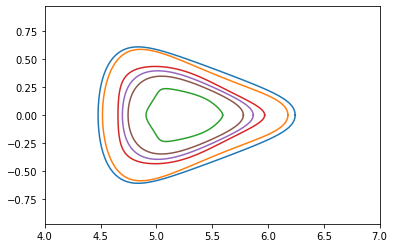

In [86]:
iSurf = 0
thetas = np.linspace(0, 2 * np.pi, 100)
phis = np.linspace(0, 2 * np.pi / 10, 3)

data = surfaces[:6].evaluate(phis, thetas) # Surfaces -5, -4, -3 are rational and failed to reconstruct

print(data['points'].shape)

for iPhi in range(len(phis)):
    plt.figure()
    for iSurf in range(0, data['points'].shape[1]):
        x, y, z = data['points'][:,iSurf,iPhi,:]
        r = np.sqrt(x**2 + y**2)
        plt.plot(r, z)
    plt.axis('equal')
    plt.xlim(4, 7)
    plt.ylim(-1.5, 1.5)
plt.show()

The obtained surfaces can also be used to calculate a mode decomposition of the magnetic field

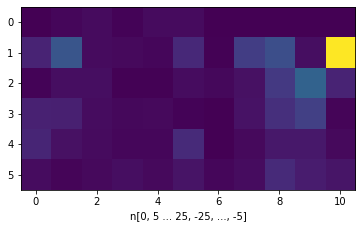

n = 0, m = 0, val = 2.84e-10
n = 5, m = 0, val = 1.97e-03
n = 10, m = 0, val = 3.32e-03
n = 15, m = 0, val = 1.18e-03
n = 20, m = 0, val = 3.19e-03
n = 25, m = 0, val = 3.06e-03
n = -25, m = 0, val = 0.00e+00
n = -20, m = 0, val = 0.00e+00
n = -15, m = 0, val = 0.00e+00
n = -10, m = 0, val = 0.00e+00
n = -5, m = 0, val = 0.00e+00
n = 0, m = 1, val = 1.08e-02
n = 5, m = 1, val = 2.86e-02
n = 10, m = 1, val = 3.08e-03
n = 15, m = 1, val = 2.94e-03
n = 20, m = 1, val = 2.02e-03
n = 25, m = 1, val = 1.24e-02
n = -25, m = 1, val = 5.86e-04
n = -20, m = 1, val = 1.96e-02
n = -15, m = 1, val = 2.59e-02
n = -10, m = 1, val = 4.02e-03
n = -5, m = 1, val = 1.09e-01
n = 0, m = 2, val = 9.29e-04
n = 5, m = 2, val = 4.12e-03
n = 10, m = 2, val = 3.99e-03
n = 15, m = 2, val = 7.77e-04
n = 20, m = 2, val = 4.90e-04
n = 25, m = 2, val = 3.46e-03
n = -25, m = 2, val = 2.13e-03
n = -20, m = 2, val = 5.03e-03
n = -15, m = 2, val = 1.79e-02
n = -10, m = 2, val = 3.43e-02
n = -5, m = 2, val = 1.09e-02
n = 

In [78]:
modes = field.calculateRadialModes(surfaces[2], field, nSym = 5, mMax = 5, nTheta = 30, nPhi = 30)
cc = modes["cosCoeffs"]
sc = modes["sinCoeffs"]

m = modes["mPol"]
n = modes["nTor"]

tot = np.sqrt(cc**2 + sc**2)

plt.imshow(tot.T)
plt.xlabel(f"n[0, {n[1,0]:.0f} ... {max(n[:,0]):.0f}, {min(n[:,0]):.0f}, ..., {n[-1,0]:.0f}]")
plt.show()

for i_m, mVal in enumerate(m[0]):
    for i_n, nVal in enumerate(n[:,0]):
        print(f"n = {nVal:.0f}, m = {mVal:.0f}, val = {tot[i_n][i_m]:.2e}")


In [21]:
help(field)

Help on MagneticConfig in module fusionsc.magnetics object:

class MagneticConfig(fusionsc.wrappers.Wrapper)
 |  MagneticConfig(val=None, msgSize=1024, byReference=False)
 |  
 |  Magnetic configuration class. Wraps an instance of fusionsc.service.MagneticField.Builder
 |  and provides access to +, -, *, and / operators.
 |  
 |  Method resolution order:
 |      MagneticConfig
 |      fusionsc.wrappers.Wrapper
 |      fusionsc.wrappers.StructWrapperBase
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __add__(self, other)
 |  
 |  __await__(self)
 |  
 |  __mul__(self, factor)
 |  
 |  __neg__(self)
 |  
 |  __radd__(self, other)
 |  
 |  __rmul__(self, factor)
 |  
 |  __sub__(self, other)
 |  
 |  __truediv__(self, divisor)
 |  
 |  calculateRadialModes(self, surfaces: fusionsc.magnetics.SurfaceArray, normalizeAgainst: 'Optional[MagneticConfig]' = None, nMax=5, mMax=5, nPhi=30, nTheta=30, nSym=1) -> Any
 |                      Calculates the radial Fourier modes of thi